# Майнор ИАД. Домашнее задание 3. YOLO.

В этом задании вы напишете и обучите свой собственный YOLO детектор. Нужно будет разобраться со статьей: понять какого формата должна быть обучающая пара (x, y), как перевести лосс из математической формулы в питоновский код - ну и конечно понять и реализовать саму архитектуру модели.

Выборка на котрой мы будем обучать модель состоит из разнообразных фотографий яблок, бананов и апельсинов. Данные скачиваем [отсюда](https://drive.google.com/file/d/1d8GSfZoWbraWCSUhX78yl4CnMFYE-5n3/view?usp=sharing).

Баллы за ДЗ распределены следующим образом: 
- Выборка для YoloV1 - 2 балла
- YOLO модель - 2 балла
- YOLO Loss - 3 балла
- Вспомогательные функции - 2 балла
- Обучение и расчет метрик - 2 балла

Для построения и обучения можно использовать как pytorch, так и pytorch-lightning.

Да-да, баллов в сумме получается 11

In [1]:
# узнать, какой GPU

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed Dec 21 16:04:15 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P0    25W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# Данная библиотека понадобится нам, чтобы обработать разметку
! pip install xmltodict pytorch-lightning -q

     |████████████████████████████████| 800 kB 15.5 MB/s 
     |████████████████████████████████| 512 kB 66.4 MB/s 
     |████████████████████████████████| 125 kB 41.3 MB/s 


In [3]:
!pip install wandb -q

     |████████████████████████████████| 1.9 MB 836 kB/s 
     |████████████████████████████████| 174 kB 19.8 MB/s 
     |████████████████████████████████| 182 kB 66.8 MB/s 
     |████████████████████████████████| 62 kB 1.6 MB/s 
     |████████████████████████████████| 173 kB 75.7 MB/s 
     |████████████████████████████████| 168 kB 76.4 MB/s 
     |████████████████████████████████| 168 kB 62.5 MB/s 
     |████████████████████████████████| 166 kB 73.3 MB/s 
     |████████████████████████████████| 166 kB 73.5 MB/s 
     |████████████████████████████████| 162 kB 69.0 MB/s 
     |████████████████████████████████| 162 kB 56.6 MB/s 
     |████████████████████████████████| 158 kB 76.0 MB/s 
     |████████████████████████████████| 157 kB 75.5 MB/s 
     |████████████████████████████████| 157 kB 67.8 MB/s 
     |████████████████████████████████| 157 kB 51.9 MB/s 
     |████████████████████████████████| 157 kB 65.8 MB/s 
     |████████████████████████████████| 157 kB 41.9 MB/s 
     |███████████

Скачаем данные

In [4]:
!wget --quiet --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://drive.google.com/uc?export=download&id=1d8GSfZoWbraWCSUhX78yl4CnMFYE-5n3' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1d8GSfZoWbraWCSUhX78yl4CnMFYE-5n3" -O data.zip && rm -rf /tmp/cookies.txt
!unzip -q data.zip
!rm data.zip
!ls -l

total 12
drwx------ 4 root root 4096 Nov 26 08:32 data
drwxr-xr-x 3 root root 4096 Dec 21 16:04 __MACOSX
drwxr-xr-x 1 root root 4096 Dec 19 14:31 sample_data


Посмотрим как выглядит один из файлов разметки

In [5]:
!cat data/train/apple_3.xml

<annotation>
	<folder>train</folder>
	<filename>apple_3.jpg</filename>
	<path>C:\tensorflow1\models\research\object_detection\images\train\apple_3.jpg</path>
	<source>
		<database>Unknown</database>
	</source>
	<size>
		<width>1000</width>
		<height>708</height>
		<depth>3</depth>
	</size>
	<segmented>0</segmented>
	<object>
		<name>apple</name>
		<pose>Unspecified</pose>
		<truncated>1</truncated>
		<difficult>0</difficult>
		<bndbox>
			<xmin>584</xmin>
			<ymin>438</ymin>
			<xmax>867</xmax>
			<ymax>708</ymax>
		</bndbox>
	</object>
	<object>
		<name>apple</name>
		<pose>Unspecified</pose>
		<truncated>0</truncated>
		<difficult>0</difficult>
		<bndbox>
			<xmin>492</xmin>
			<ymin>141</ymin>
			<xmax>740</xmax>
			<ymax>394</ymax>
		</bndbox>
	</object>
	<object>
		<name>apple</name>
		<pose>Unspecified</pose>
		<truncated>0</truncated>
		<difficult>0</difficult>
		<bndbox>
			<xmin>176</xmin>
			<ymin>199</ymin>
			<xmax>490</xmax>
			<ymax>466</ymax>
		</bndbox>
	</object>
	<obj

## Релизуйте выборку для YoloV1 - 2 балла

In [6]:
import os
import cv2
import json
import glob
import tqdm
import xmltodict

from IPython.core.display import struct

from typing import List

import pandas as pd
import numpy as np

import torch
import torchvision
from torch import nn
from torch.utils.data import Dataset, DataLoader

import pytorch_lightning as pl

import albumentations as A
import albumentations.pytorch

from PIL import Image

import matplotlib.pyplot as plt

from sklearn.metrics import auc
# Добавьте необходимые вам библиотеки, если их не окажется в списке выше
from albumentations.pytorch import ToTensorV2
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import ModelCheckpoint
from tqdm import tqdm
from IPython.display import clear_output


%matplotlib inline
%config InlineBackend.figure_format = 'retina'

Так как в этом домашнем задании использовать аугментации для обучения __обязательно__ - советуем воспользоваться библиотекой albumentations.

Она  особенно удобна, поскольку умеет сама вычислять новые координаты bounding box'ов после трансформаций картинки. Для знакомства с этим механизмом советуем следующий [гайд](https://albumentations.ai/docs/getting_started/bounding_boxes_augmentation/). 

Вы все еще можете избрать путь torchvision.transforms, вам потребуется знакомый нам метод `__getitem__`, однако вычислять новые координаты bounding box'ов после трансформаций вам придётся вручную

__Обратите внимание__ на то, что в статье коробки предсказаний параметризуются через: _(x_center, y_center, width, height)_ (причем эти значения _относительные_), а в наших файлах - это _(x_min, y_min, x_max, y_max)_

Также, помните что модель должна предсказывать как прямоугольник с обьектом, так и вероятности каждого класса!

In [7]:
class2tag = {"apple": 1, "orange": 2, "banana": 3}

class FruitDataset(Dataset):
    def __init__(self, data_dir, transforms=None, S=7, B=2, C=3):
        # с помощью glob.glob ищем путь к файлам
        self.image_paths =  glob.glob(os.path.join(data_dir, "*.jpg"))
        self.box_paths = glob.glob(os.path.join(data_dir, "*.xml"))

        # я добавил в init S, B и C, как было предложено на консультации,
        # чтобы составить таргет правильной формы
        self.S = S
        self.B = B
        self.C = C

        assert len(self.image_paths) == len(self.box_paths)

        self.transforms = transforms

    # Координаты прямоугольников советуем вернуть именно в формате (x_center, y_center, width, height)
    def __getitem__(self, idx):
        # обращаемся к пути к нужной коробке, найденному ранее
        box_path = self.box_paths[idx]

        with open(box_path) as box:
            my_box = xmltodict.parse(box.read())
            path = str(my_box['annotation']['path'])
            path = path.replace('\\', '/').split('images')[1]
            image_path = 'data' + path

        # нашли путь, конвертируем в RGB
        image = np.array(Image.open(image_path).convert("RGB"))
        # парсим коробки и классы
        boxes, class_labels = self.__get_boxes_from_xml(box_path)
        # обработаем координаты
        width, height = len(image[0]), len(image)
        boxes = [self.__convert_to_yolo_box_params(i, width, height) for i in boxes]

        # применим трансформации, если они есть
        if self.transforms:
            image = self.transforms(image=image, 
                                    bboxes=boxes, 
                                    class_labels = class_labels)["image"]
        # создадим таргет и заполним его нулями
        target_tensor = torch.zeros([self.S, self.S, (self.B * 5 + self.C)], 
                                    dtype=torch.float32)

        # заведем нужные параметры вероятностей классов
        box_class = {1 : torch.tensor([1, 0, 0]),  # apple
                     2 : torch.tensor([0, 1, 0]),  # orange
                     3 : torch.tensor([0, 0, 1])}  # banana

        # обработаем боксы
        # поскольку мы делим картинку на сетку 7х7, по координатам можно определить то,
        # куда относится тот или иной бокс, разделив его координату нацело на 7
        for i in range(len(boxes)):
            grid_x = int(boxes[i][0] // (1/7) - 1 * (boxes[i][0] // (1/7) == 7))
            grid_y = int(boxes[i][1] // (1/7) - 1 * (boxes[i][1] // (1/7) == 7))

            # теперь соединяем всю нужную информаци про тензор в вектор размера 13
            target_tensor[grid_x, grid_y] = torch.cat((torch.tensor(boxes[i]),       # 4 координаты первого бокса в YOLO формате
                                                       torch.tensor([1]),            # уверенность для первого бокса, равная 1
                                                       torch.tensor(boxes[i]),       # 4 координаты второго бокса в YOLO формате
                                                       torch.tensor([1]),            # уверенность для второго бокса, равная 1
                                                       box_class[class_labels[i]]))  # вероятности классов в данной ячейке

        # меняем тип данных, иначе ошибка (int)
        image = image.to(torch.float32)
        
        return image, target_tensor

    def __len__(self):
        return len(self.image_paths)

    def __get_boxes_from_xml(self, xml_filename: str):
        """
        Метод, который считает и распарсит (с помощью xmltodict) переданный xml
        файл и вернет координаты прямоугольников обьектов на соответсвующей фотографии
        и название класса обьекта в каждом прямоугольнике

        Обратите внимание, что обьектов может быть как несколько, так и один единственный
        """
        boxes = []
        class_labels = []

        with open(xml_filename) as box:
            my_box = xmltodict.parse(box.read())
            
            if type(my_box['annotation']['object']) == list:  # если классов несколько
                for fruit in my_box['annotation']['object']:
                    # добавляем класс
                    class_labels.append(class2tag[fruit['name']])
                    # добавляем координаты
                    coordinates = [
                        int(fruit['bndbox']['xmin']),
                        int(fruit['bndbox']['ymin']),
                        int(fruit['bndbox']['xmax']),
                        int(fruit['bndbox']['ymax'])
                    ]
                    boxes.append(coordinates)
            else:
                # добавляем класс
                class_labels.append(class2tag[my_box['annotation']['object']['name']])
                # добавляем координаты
                coordinates = [
                    int(my_box['annotation']['object']['bndbox']['xmin']),
                    int(my_box['annotation']['object']['bndbox']['ymin']),
                    int(my_box['annotation']['object']['bndbox']['xmax']),
                    int(my_box['annotation']['object']['bndbox']['ymax'])
                ]
                boxes.append(coordinates)

            return boxes, class_labels

    def __convert_to_yolo_box_params(self, box_coordinates: List[int], im_w, im_h):
        """
        Перейти от [xmin, ymin, xmax, ymax] к [x_center, y_center, width, height].
        
        Обратите внимание, что параметры [x_center, y_center, width, height] - это
        относительные значение в отрезке [0, 1]

        :param: box_coordinates - координаты коробки в формате [xmin, ymin, xmax, ymax]
        :param: im_w - ширина исходного изображения
        :param: im_h - высота исходного изображения

        :return: координаты коробки в формате [x_center, y_center, width, height]
        """
        ans = []

        ans.append((box_coordinates[0] + box_coordinates[2]) / 2 / im_w)  # x_center
        ans.append((box_coordinates[1] + box_coordinates[3]) / 2 / im_h)  # y_center
      
        ans.append((box_coordinates[2] - box_coordinates[0]) / im_w)  # width
        ans.append((box_coordinates[3] - box_coordinates[1]) / im_h)  # height
        return ans

Небольшая проверка, что все работает:

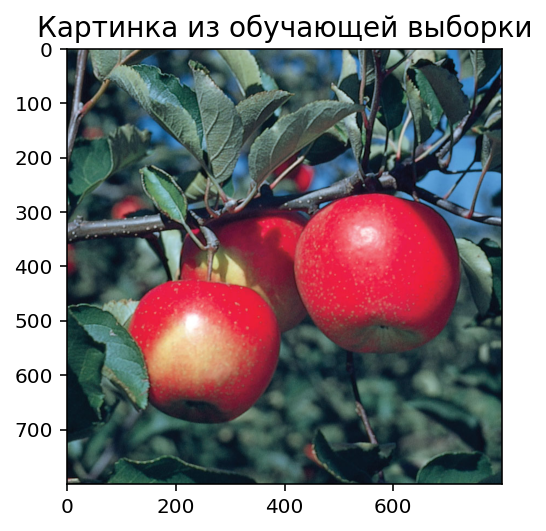

In [8]:
# это до трансформации
pic = np.array(Image.open('/content/data/train/apple_13.jpg').convert("RGB"))
plt.title('Картинка из обучающей выборки', fontsize=14)
plt.imshow(pic);

Интересный факт: в начале я попробовал честно посчитать параметры для нормализации (ниже). Они получались нетипично большими. Если я использовал их, то все ломалось - выдавались крайне странные картинки (это логично, если использовать такие параметры). 

Но затем я вставил параметры по умолчанию из 3 семинара (значения по всем каналам равны 0.5) - все заработало. В предыдущих работах я считал так, и все получалось.

In [9]:
WIDTH, HEIGHT = 448, 448

train_transform = A.Compose([
# A.augmentations.transforms.Normalize (mean=(207.3671, 176.2520, 137.2872), std=(44.7586, 59.4305, 80.5275)),
A.augmentations.transforms.Normalize (mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
A.augmentations.geometric.resize.Resize(height = HEIGHT, width = WIDTH),
A.augmentations.transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=1.5, hue=0.2, p=0.5),
A.augmentations.geometric.transforms.Affine(scale=0.2, translate_percent=0.2, p=0.5),
A.HorizontalFlip(p=0.5),
ToTensorV2()
],
                             bbox_params=A.BboxParams(format='yolo',
                                                      label_fields=['class_labels']))

test_transform = A.Compose([
# A.augmentations.transforms.Normalize (mean=(207.3671, 176.2520, 137.2872), std=(44.7586, 59.4305, 80.5275)),
A.augmentations.transforms.Normalize (mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
A.augmentations.geometric.resize.Resize(height = HEIGHT, width = WIDTH),
ToTensorV2()
],
                            bbox_params=A.BboxParams(format='yolo',
                                                     label_fields=['class_labels']))

In [10]:
train_dataset = FruitDataset(
    transforms=train_transform,
    data_dir="./data/train"
    )

val_dataset = FruitDataset(
    transforms=test_transform, 
    data_dir="./data/test"
    )

# Немного проверок, чтобы убедиться в правильности направления решения
assert isinstance(train_dataset[0], tuple)
assert len(train_dataset[0]) == 2
assert isinstance(train_dataset[0][0], torch.Tensor)
print("Тесты успешно пройдены")

Тесты успешно пройдены


Далее я посчитаю параметры для нормализации картинок:

In [11]:
# источник: мое предыдущее ДЗ

means = torch.zeros(1, 3).squeeze()
stds = torch.zeros(1, 3).squeeze()

for image, _ in train_dataset:
    means += image.mean(dim = (1,2)) # суммируем средние
    stds += image.std(dim = (1,2))   # суммируем станд. откл.

print(means / len(train_dataset)) # делим средние на размер датасета
print(stds / len(train_dataset))  # делим станд. откл. на размер датасета

# здесь выводятся параметры уже после нормализации, т.е. не те, которые получаются по "голым" картинкам

/usr/local/lib/python3.8/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


tensor([0.3579, 0.2779, 0.1695])
tensor([0.2105, 0.2507, 0.3016])


Определим даталодер:

In [15]:
train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=4,
    shuffle=True,
    num_workers=2,
    pin_memory=True)

val_dataloader = DataLoader(
    dataset=val_dataset,
    batch_size=4,
    shuffle=False,
    num_workers=2,
    pin_memory=True)

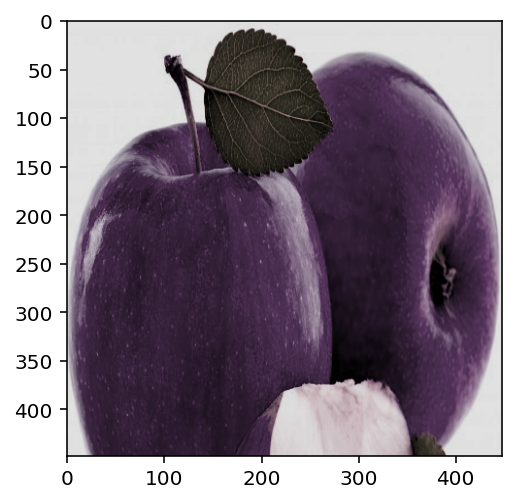

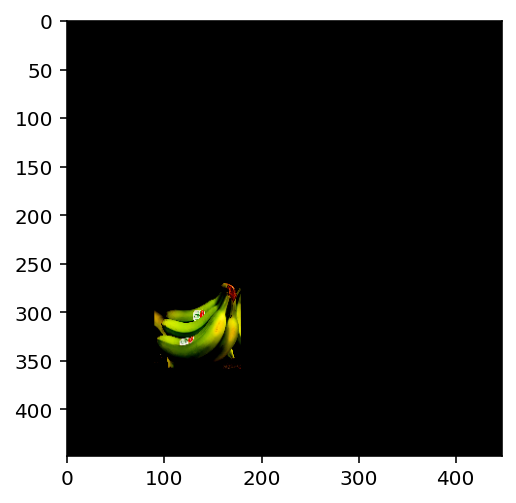

In [13]:
# код для показа из прошлого дз
for batch in train_dataloader:
    images, class_nums = batch
    plt.imshow(images[2].permute(1, 2, 0))
    plt.show()
    plt.imshow(images[1].permute(1, 2, 0))
    plt.show()
    break

Визуально все работает хорошо: картинки ресайзятся, видно, что нормализация тоже работает.

Параметры для аугментаций и конкретные типы аугментаций были взяты из рекомендаций авторов в оригинальной статье: "For data augmentation we introduce random scaling and translations of up to 20% of the original image size. We also randomly adjust the exposure and saturation of the image by up to a factor of 1:5 in the HSV color space."

Теперь определим функцию для рассчета Intersection Over Union по 4 углам двух прямоугольников

In [16]:
def intersection_over_union(predicted_bbox, gt_bbox) -> float:
    """
    Intersection Over Union для двух прямоугольников

    :param: predicted_bbox - [x_min, y_min, x_max, y_max]
    :param: gt_bbox - [x_min, y_min, x_max, y_max]
    
    :return: Intersection Over Union
    """

    intersection_bbox = np.array(
        [
            max(predicted_bbox[0], gt_bbox[0]),
            max(predicted_bbox[1], gt_bbox[1]),
            min(predicted_bbox[2], gt_bbox[2]),
            min(predicted_bbox[3], gt_bbox[3]),
        ]
    )

    intersection_area = max(intersection_bbox[2] - intersection_bbox[0], 0) * max(
        intersection_bbox[3] - intersection_bbox[1], 0
    )
    area_dt = (predicted_bbox[2] - predicted_bbox[0]) * (predicted_bbox[3] - predicted_bbox[1])
    area_gt = (gt_bbox[2] - gt_bbox[0]) * (gt_bbox[3] - gt_bbox[1])

    union_area = area_dt + area_gt - intersection_area

    iou = intersection_area / union_area
    return iou

Теперь начинается основная часть домашнего задания: обучите модель YOLO для object detection на __обучающем__ датасете. 

 - Создайте модель и функцию ошибки YoloV1 прочитав [оригинальную статью](https://paperswithcode.com/paper/you-only-look-once-unified-real-time-object)
 - Напишите функцию обучения модели
 - Используйте аугментации

## Реализуйте Модель - 2 балла

Копировать точное количество слоев и параметры сверток необязательно. Главное - чтобы модель работала по принципу, описанному в статье и делала предсказание в представленном формате.


В качестве подсказки напомним, что выходом модели __для каждого обьекта__ должен быть тензор размера
__S * S * (B * 5 + С)__, где все параметры имеют такое же значение, как и в статье: 

- S - количество ячеек на которое разбивается изображение по вертикали/горизонтали
- В - количество предсказываемых прямоугольников в каждой ячейке
- 5 - количество параметров для определения каждого прямоугольника (x_center, y_center, width, height, confidence)
- С - количество классов (apple, banana, orange)

Таким образом, мы для каждого окна размера __S x S__ предсказываем __В__ коробо и один класс

In [17]:
# шаблон не пригодился
#  class CNNBlock(nn.Module):  # можно поменять на Lightning
#     def __init__(self, in_channels, out_channels, is_max_pool:bool=False, **kwargs):
        
#         super().__init__()

#         self.conv = nn.Conv2d(in_channels, out_channels, **kwargs)
#         self.batchnorm = nn.BatchNorm2d(out_channels)  # в статье еще не знали про батчнорм, но мы то из будущего ...
#         self.leakyrelu = nn.LeakyReLU(0.1)

#         self.is_maxpool = is_max_pool  # не после каждой свертки нужно делать maxpool
#         self.maxpool = nn.MaxPool2d(2)
        
#     def forward(self, x):
#         x = self.leakyrelu(self.batchnorm(self.conv(x)))

#         if self.is_maxpool:
#             x = self.maxpool(x)

#         return x
    
class YOLO(nn.Module):
    def __init__(self, S=7, B=2, C=3):
        """
        :param: S * S - количество ячеек на которые разбивается изображение
        :param: B - количество предсказанных прямоугольников в каждой ячейке
        :param: C - количество классов
        """
        
        super(YOLO, self).__init__()

        self.S = S
        self.B = B
        self.C = C

        self.Conv_Layer_1 = nn.Sequential(
            nn.Conv2d(3, 64, 7, stride=2, padding=3),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(2, stride=2)
        )
        self.Conv_Layer_2 = nn.Sequential(
            nn.Conv2d(64, 192, 3, padding=1),
            nn.BatchNorm2d(192),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(2, stride =2)
        )
        self.Conv_Layer_3 = nn.Sequential(
            nn.Conv2d(192, 128, 1),
            nn.LeakyReLU(0.1),
            nn.Conv2d(128, 256, 3, padding=1),
            nn.LeakyReLU(0.1),
            nn.Conv2d(256, 256, 1),
            nn.LeakyReLU(0.1),
            nn.Conv2d(256, 512, 3, padding=1),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(2, stride=2)
        )
        self.Conv_Layer_4 = nn.Sequential(
            nn.Conv2d(512, 256, 1),
            nn.LeakyReLU(0.1),
            nn.Conv2d(256, 512, 3, padding=1),
            nn.LeakyReLU(0.1),
            nn.Conv2d(512, 256, 1),
            nn.LeakyReLU(0.1),
            nn.Conv2d(256, 512, 3, padding=1),
            nn.LeakyReLU(0.1),
            nn.Conv2d(512, 256, 1),
            nn.LeakyReLU(0.1),
            nn.Conv2d(256, 512, 3, padding=1),
            nn.LeakyReLU(0.1),
            nn.Conv2d(512, 256, 1),
            nn.LeakyReLU(0.1),
            nn.Conv2d(256, 512, 3, padding=1),
            nn.LeakyReLU(0.1),
            nn.Conv2d(512, 512, 1),
            nn.LeakyReLU(0.1),
            nn.Conv2d(512, 1024, 3, padding=1),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(2, stride=2)
        )
        self.Conv_Layer_5 = nn.Sequential(
            nn.Conv2d(1024, 512, 1),
            nn.LeakyReLU(0.1),
            nn.Conv2d(512, 1024, 3, padding=1),
            nn.LeakyReLU(0.1),
            nn.Conv2d(1024, 512, 1),
            nn.LeakyReLU(0.1),
            nn.Conv2d(512, 1024, 3, padding=1),
            nn.LeakyReLU(0.1),
            nn.Conv2d(1024, 1024, 3, padding=1),
            nn.LeakyReLU(0.1),
            nn.Conv2d(1024, 1024, 3, stride=2, padding=1),
            nn.LeakyReLU(0.1)
        )
        self.Conv_Layer_6 = nn.Sequential(
            nn.Conv2d(1024, 1024, 3, padding=1),
            nn.LeakyReLU(0.1),
            nn.Conv2d(1024, 1024, 3, padding=1)
        )

        self.FC_Layer = nn.Sequential(
            nn.Linear(50176, 4096),
            nn.Dropout(0.5),
            nn.LeakyReLU(0.1),
            nn.Linear(4096, 7*7*13)
        )

        self.flatten = nn.Flatten()

    def forward(self, x):
        x = self.Conv_Layer_1(x)
        x = self.Conv_Layer_2(x)
        x = self.Conv_Layer_3(x)
        x = self.Conv_Layer_4(x)
        x = self.Conv_Layer_5(x)
        x = self.Conv_Layer_6(x)
        # растягиваем
        x = self.flatten(x)
        # полносвязный слой
        x = self.FC_Layer(x)
        
        return x 

# Убедитесь на одном изображении, что предсказания вашей модели имеют верное количество значений

temp_model = YOLO()
expected_output_shape = temp_model.S * temp_model.S * (5 * temp_model.B + temp_model.C)

# по совету семинариста я добавил еще одну размерность через torch.unsqueeze, означающую батч, чтобы модель прошла тест
testing_image = torch.unsqueeze(train_dataset[0][0], 0)

assert temp_model(testing_image).reshape(-1).shape[0] == expected_output_shape

## Реализуйте YoloLoss - 3 балла

In [18]:
class YoloLoss(nn.Module):
    def __init__(self, S=7, B=2, C=3):
        """
        :param: S * S - количество ячеек на которые разбивается изображение
        :param: B - количество предсказанных прямоугольников в каждой ячейке
        :param: C - количество классов
        """
        
        super().__init__()
        self.mse = nn.MSELoss(reduction="sum")

        self.S = S
        self.B = B
        self.C = C

        self.lambda_noobj = 0.5
        self.lambda_coord = 5

    def forward(self, predictions, target):
        '''
        Считается loss для batch размера torch.Size([batch_size, S, S, (B * 5 + С)])
        В текущей реализации для torch.Size([batch_size, 7, 7, 13])
        Последний элемент - вектор размера 13, содержащий следующую информацию:
        [x_center, y_center, width, height, confidence,  # параметры для определения 1-го прямоугольника + уверенность
         x_center, y_center, width, height, confidence,  # параметры для определения 2-го прямоугольника + уверенность
         apple_prob, bananae_prob, orangee_prob]         # вероятности классов
        '''
        # заводим счетчик лосса
        yolo_loss = 0

        # проходимся по батчу
        for batch_idx in range(target.shape[0]):
            # проходимся по одной координате S
            for S_1 in range(target.shape[1]):
                # проходимся по другой координате S
                for S_2 in range(target.shape[2]):
                    # забираем нужные координаты для необходимых коробок
                    x_1_pred = predictions[batch_idx][S_1][S_2][0]
                    x_1_true = target[batch_idx][S_1][S_2][0]
                    y_1_pred = predictions[batch_idx][S_1][S_2][1]
                    y_1_true = target[batch_idx][S_1][S_2][1]

                    w_1_pred = predictions[batch_idx][S_1][S_2][2]
                    w_1_true = target[batch_idx][S_1][S_2][2]
                    h_1_pred = predictions[batch_idx][S_1][S_2][3]
                    h_1_true = target[batch_idx][S_1][S_2][3]


                    x_2_pred = predictions[batch_idx][S_1][S_2][5]
                    x_2_true = target[batch_idx][S_1][S_2][5]
                    y_2_pred = predictions[batch_idx][S_1][S_2][6]
                    y_2_true = target[batch_idx][S_1][S_2][6]

                    w_2_pred = predictions[batch_idx][S_1][S_2][7]
                    w_2_true = target[batch_idx][S_1][S_2][7]
                    h_2_pred = predictions[batch_idx][S_1][S_2][8]
                    h_2_true = target[batch_idx][S_1][S_2][8]

                    # уверенности
                    confidence_1_pred = predictions[batch_idx][S_1][S_2][4]
                    confidence_2_pred = predictions[batch_idx][S_1][S_2][9]

                    confidence_1_true = target[batch_idx][S_1][S_2][4]
                    confidence_2_true = target[batch_idx][S_1][S_2][9]

                    # вероятности классов
                    prob_1_pred = predictions[batch_idx][S_1][S_2][10]
                    prob_2_pred = predictions[batch_idx][S_1][S_2][11]
                    prob_3_pred = predictions[batch_idx][S_1][S_2][12]

                    prob_1_true = target[batch_idx][S_1][S_2][10]
                    prob_2_true = target[batch_idx][S_1][S_2][11]
                    prob_3_true = target[batch_idx][S_1][S_2][12]

                    # определяем координаты для расчета IOU:
                    # predicted_bbox - [x_min, y_min, x_max, y_max]
                    # gt_bbox        - [x_min, y_min, x_max, y_max]
                    predicted_bbox_1 = [
                        (x_1_pred - w_1_pred / 2).cpu().detach().numpy(), # x_min
                        (y_1_pred - h_1_pred / 2).cpu().detach().numpy(), # y_min  
                        (x_1_pred + w_1_pred / 2).cpu().detach().numpy(), # x_max
                        (y_1_pred + h_1_pred / 2).cpu().detach().numpy()  # y_max
                    ]

                    predicted_bbox_2 = [
                        (x_2_pred - w_2_pred / 2).cpu().detach().numpy(), # x_min
                        (y_2_pred - h_2_pred / 2).cpu().detach().numpy(), # y_min  
                        (x_2_pred + w_2_pred / 2).cpu().detach().numpy(), # x_max
                        (y_2_pred + h_2_pred / 2).cpu().detach().numpy()  # y_max
                    ]

                    gt_bbox = [
                        (x_1_true - w_1_true / 2).cpu().detach().numpy(), # x_min
                        (y_1_true - h_1_true / 2).cpu().detach().numpy(), # y_min  
                        (x_1_true + w_1_true / 2).cpu().detach().numpy(), # x_max
                        (y_1_true + h_1_true / 2).cpu().detach().numpy()  # y_max
                    ]

                    iou_1 = intersection_over_union(predicted_bbox_1, gt_bbox)
                    iou_2 = intersection_over_union(predicted_bbox_2, gt_bbox)

                    # обработаем случаи, когда таргета нет в ячейке
                    if confidence_1_true == 0 and confidence_1_true == 0:
                        yolo_loss += self.lambda_noobj * (confidence_1_pred - confidence_1_true)**2
                        yolo_loss += self.lambda_noobj * (confidence_2_pred - confidence_2_true)**2
                    # обработаем случаи, когда таргета есть в ячейке
                    else:
                        # считаем слагаемые
                        loss_x_y_1 = (x_1_true - x_1_pred)**2 + (y_1_true - y_1_pred)**2
                        loss_x_y_2 = (x_2_true - x_2_pred)**2 + (y_2_true - y_2_pred)**2

                        loss_w_h_1 = (torch.sqrt(w_1_true) - torch.sqrt(w_1_pred))**2 + (torch.sqrt(h_1_true) - torch.sqrt(h_1_pred))**2
                        loss_w_h_2 = (torch.sqrt(w_2_true) - torch.sqrt(w_2_pred))**2 + (torch.sqrt(h_2_true) - torch.sqrt(h_2_pred))**2

                        # штраф за координаты
                        yolo_loss += self.lambda_coord * (loss_x_y_1 + loss_x_y_2)
                        yolo_loss += self.lambda_coord * (loss_w_h_1 + loss_w_h_2)
                        # штраф за уверенность
                        yolo_loss += (confidence_1_true - confidence_1_pred)**2
                        yolo_loss += (confidence_2_true - confidence_2_pred)**2
                        # штраф за вероятности
                        yolo_loss += (prob_1_pred - prob_1_true)**2
                        yolo_loss += (prob_2_pred - prob_2_true)**2
                        yolo_loss += (prob_3_pred - prob_3_true)**2

        return yolo_loss

Небольшой тест лосса для YOLO:

In [19]:
y_true = next(iter(train_dataloader))[1] # реальный таргет
y_zero = torch.zeros([4,7,7,13])         # таргет из 0
y_pred_rand = torch.rand([4,7,7,13])     # рандомный таргет

/usr/local/lib/python3.8/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [20]:
loss = YoloLoss()
loss.forward(y_zero, y_pred_rand)  # штраф между таргетом из 0 и ранд. таргетом большой

tensor(3535.1194)

In [21]:
loss.forward(y_true, y_pred_rand)  # штраф между реальный таргетом и ранд. таргетом большой

tensor(3420.9417)

In [22]:
loss.forward(y_pred_rand, y_pred_rand)  # штраф между одинаковым таргетом нулевой

tensor(0.)

In [23]:
loss.forward(y_true, y_true)  # штраф между одинаковым таргетом нулевой

<ipython-input-16-55e94c296b49>:28: RuntimeWarning: invalid value encountered in float_scalars
  iou = intersection_area / union_area


tensor(0.)

Лосс работает хорошо: штраф равен 0 для одинаковых таргетов, большой для рандомного тензора и тензора из нулей.

## Реализуйте дополнительные функции из статьи - 2 балла

In [24]:
# источник: https://github.com/aladdinpersson/Machine-Learning-Collection/blob/088bdb63e9ccba93da9f14289cb4e66f67539afb/ML/Pytorch/object_detection/YOLO/utils.py
from collections import Counter

def non_max_suppression(bboxes, iou_threshold, threshold):
    """
    Проводим операцию Non Max Suppression для избавления от ненужных боксов
    bboxes: список из списков со всеми коробками вида: [x1, y1, x2, y2, уверенность модели]
    iou_threshold: порог для корректных коробок
    threshold: порог для удаления предсказанных коробок (отдельно от IOU)
    Возвращаем: список коробок после применения Non Max Suppression
    """
    # убедимся, что на вход список
    assert type(bboxes) == list

    # сортируем по уверенности модели
    bboxes = [box for box in bboxes if box[4] > threshold]
    bboxes = sorted(bboxes, key=lambda x: x[4], reverse=True)

    best_bboxes = []

    # проходимся по коробкам
    while bboxes:
        new_box = bboxes.pop(0)

        bboxes = [
            box
            for box in bboxes
            if box[0] != new_box[0]
            or intersection_over_union(
                torch.tensor(new_box[:4]),
                torch.tensor(box[:4])
            )
            < iou_threshold
        ]

        best_bboxes.append(new_box)

    return best_bboxes

def mean_average_precision(pred_boxes, true_boxes, iou_threshold=0.5, num_classes=3):
    """
    Считаем метрику Mean Average Precision
    pred_boxes: список списков со всеми коробками вида [x1, y1, x2, y2, уверенность модели, вероятности классов (3)]
    true_boxes: истинные боксы на подобие pred_boxes
    iou_threshold: порог для корректных коробок
    num_classes: число классов
    Возвращаем: значение метрики mAP по всем классам
    """

    # складываем сюда AP по классам
    average_precisions = []

    epsilon = 1e-6

    # нужно разделить коробки по предсказанному в них классу
    pred_boxes_1, pred_boxes_2, pred_boxes_3 = [], [], []
    true_boxes_1, true_boxes_2, true_boxes_3 = [], [], []

    # определяем предсказанный класс
    for pred_box in torch.tensor(pred_boxes):
        if torch.argmax(pred_box[5:-1]) == 0:   # в срезе [5:-1] лежат вероятности классов
            pred_boxes_1.append(pred_box)
        elif torch.argmax(pred_box[5:-1]) == 1:
            pred_boxes_2.append(pred_box)
        elif torch.argmax(pred_box[5:-1]) == 2:
            pred_boxes_3.append(pred_box)
        else:
            assert False # что-то пошло не так

    # определяем истинный класс
    for true_box in torch.tensor(true_boxes):
        if torch.argmax(true_box[5:-1]) == 0:
            true_boxes_1.append(true_box)
        elif torch.argmax(true_box[5:-1]) == 1:
            true_boxes_2.append(true_box)
        elif torch.argmax(true_box[5:-1]) == 2:
            true_boxes_3.append(true_box)
        else:
            assert False # что-то пошло не так

    # складываем их вместе
    all_pred_boxes = [pred_boxes_1,
                      pred_boxes_2, 
                      pred_boxes_3]

    all_true_boxes = [true_boxes_1,
                      true_boxes_2,
                      true_boxes_3]

    # добавляем id для сортировки далее
    for i in range(len(all_pred_boxes)):
        for j in range(len(pred_boxes_1)):
            pred_boxes_1[j] = torch.cat((pred_boxes_1[j], torch.tensor([j])))
            true_boxes_1[j] = torch.cat((true_boxes_1[j], torch.tensor([j])))

        for j in range(len(pred_boxes_1), len(pred_boxes_1) + len(pred_boxes_2)):
            pred_boxes_2[j] = torch.cat((pred_boxes_2[j], torch.tensor([j])))
            true_boxes_2[j] = torch.cat((true_boxes_2[j], torch.tensor([j])))

        for j in range(len(pred_boxes_1) + len(pred_boxes_2), len(pred_boxes_1) + len(pred_boxes_2) + len(pred_boxes_3)):
            pred_boxes_3[j] = torch.cat((pred_boxes_3[j], torch.tensor([j])))
            true_boxes_3[j] = torch.cat((true_boxes_3[j], torch.tensor([j])))


    for c in range(num_classes):
        # ищем число боксов для каждого изображения
        # и записываем как {0:3, 1:5}
        # ключ - idx картинки, значение - число боксов
        amount_bboxes = Counter([gt[-1] for gt in all_true_boxes[c]])

        # конвертируем в другой формат: {0:torch.tensor[0,0,0], 1:torch.tensor[0,0,0,0,0]}
        for key, val in amount_bboxes.items():
            amount_bboxes[key] = torch.zeros(val)

        # сортируем по уверенности модели
        all_pred_boxes[c].sort(key=lambda x: x[4], reverse=True)
        TP = torch.zeros((len(all_pred_boxes[c])))
        FP = torch.zeros((len(all_pred_boxes[c])))
        total_true_bboxes = len(all_true_boxes[c])
        
        # если ничего нет, можно пропустить
        if total_true_bboxes == 0:
            continue

        for detection_idx, detection in enumerate(all_pred_boxes[c]):
            # вытаскиваем истинные боксы, которые имеют такие же idx как у предсказанных
            ground_truth_img = [
                bbox for bbox in all_true_boxes[c] if bbox[-1] == detection[-1]
            ]

            num_gts = len(ground_truth_img)
            best_iou = 0

            for idx, gt in enumerate(ground_truth_img):
                iou = intersection_over_union(
                    torch.tensor(detection[:4]),
                    torch.tensor(gt[:4]))

                if iou > best_iou:
                    best_iou = iou
                    best_gt_idx = idx

            if best_iou > iou_threshold:
                if amount_bboxes[detection[-1]][best_gt_idx] == 0:
                    # это true positive
                    TP[detection_idx] = 1
                    amount_bboxes[detection[-1]][best_gt_idx] = 1
                else:
                    FP[detection_idx] = 1
            # это false positive
            else:
                FP[detection_idx] = 1

        TP_cumsum = torch.cumsum(TP, dim=0)
        FP_cumsum = torch.cumsum(FP, dim=0)
        recalls = TP_cumsum / (total_true_bboxes + epsilon)
        precisions = torch.divide(TP_cumsum, (TP_cumsum + FP_cumsum + epsilon))
        precisions = torch.cat((torch.tensor([1]), precisions))
        recalls = torch.cat((torch.tensor([0]), recalls))
        average_precisions.append(torch.trapz(precisions, recalls))

    return sum(average_precisions) / len(average_precisions)        

# дополнительные функции для работы get_bound_boxes
def convert_cellboxes(predictions, S=7):
    """
    Преобразует bounding boxes из YOLO с размером сетки S на S
    в соотношения всего изображения, а не в соотношения относительно ячеек
    """

    predictions = predictions.to("cpu")
    batch_size = predictions.shape[0]
    predictions = predictions.reshape(batch_size, 7, 7, 13)
    bboxes1 = predictions[..., :4]   # координаты первого бокса
    bboxes2 = predictions[..., 5:9]  # координаты второго бокса
    scores = torch.cat(
        (predictions[..., 4].unsqueeze(0), predictions[..., 9].unsqueeze(0)), dim=0  # уверенности модели
    )
    best_box = scores.argmax(0).unsqueeze(-1)
    best_boxes = bboxes1 * (1 - best_box) + best_box * bboxes2
    cell_indices = torch.arange(7).repeat(batch_size, 7, 1).unsqueeze(-1)
    x = 1 / S * (best_boxes[..., :1] + cell_indices)
    y = 1 / S * (best_boxes[..., 1:2] + cell_indices.permute(0, 2, 1, 3))
    w_y = 1 / S * best_boxes[..., 2:4]
    converted_bboxes = torch.cat((x, y, w_y), dim=-1)
    predicted_class = predictions[..., -3:].argmax(-1).unsqueeze(-1)  # вероятности классов
    best_confidence = torch.max(predictions[..., 4], predictions[..., 9]).unsqueeze(  # уверенности модели
        -1
    )
    converted_preds = torch.cat(
        (predicted_class, best_confidence, converted_bboxes), dim=-1
    )

    return converted_preds


def cellboxes_to_boxes(out, S=7):
    '''
    Для обработки функцией non_max_suppression
    '''
    converted_pred = convert_cellboxes(out).reshape(out.shape[0], S * S, -1)
    converted_pred[..., 0] = converted_pred[..., 0].long()
    all_bboxes = []

    for ex_idx in range(out.shape[0]):
        bboxes = []

        for bbox_idx in range(S * S):
            bboxes.append([x.item() for x in converted_pred[ex_idx, bbox_idx, :]])
        all_bboxes.append(bboxes)

    return all_bboxes

def get_bound_boxes(loader, model, device, iou_threshold=.5, threshold=.4):
    '''
    device: CPU или CUDA
    '''
    all_pred_boxes = []
    all_true_boxes = []

    # переводим модель в валиидационный режим
    model.eval()
    train_idx = 0

    for batch_idx, (x, labels) in enumerate(loader):
        x = x.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            predictions = model(x)

        batch_size = x.shape[0]
        true_bboxes = cellboxes_to_boxes(labels)
        bboxes = cellboxes_to_boxes(predictions)

        for idx in range(batch_size):
            nms_boxes = non_max_suppression(
                bboxes[idx],
                iou_threshold=iou_threshold,
                threshold=threshold
            )

            for nms_box in nms_boxes:
                all_pred_boxes.append([train_idx] + nms_box)

            for box in true_bboxes[idx]:
                if box[1] > threshold:
                    all_true_boxes.append([train_idx] + box)

            train_idx += 1

    # переводим модель обратно в режим обучения
    model.train()
    return all_pred_boxes, all_true_boxes

## Обучите модель и посчитайте метрики для задачи детекции - 2 балла 

Несмотря на то, что в этом блоке ничего сильно нового для вас не ожидается и за него формально дается лишь два балла - провести обучение очень важно для понимания того, насколько правильно реализована ваша модель и лосс.

В процессе обучения будет видно все ли размерности совпадают, падает ли лосс и растут ли метрики целевой задачи, поэтому на практике этот пункт гораздо оказывается гораздо важнее.

Определим логер с помощью **wandb**.

In [25]:
import wandb

# логинимся
wandb.login() # уже авторизованы, id не вводим
# инициализируем проект
wandb.init(project="hw-3", name='test-3')

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: rubanoww. Use `wandb login --relogin` to force relogin


In [141]:
wandb.finish()

YOLO-loss train,▂▂▁▂▁▄▂▂▅▅▂▁▂▂▁▁▁▄▂▄▂▂▄▂▁▂▂▃▂▂▃▂▃▂▁▄▁▂█▂
YOLO-loss val,▅▂▂▂▂▂▁▂▁▁█
mAP,▁▁▁▁▁▁▁▁▁▁▁
YOLO-loss train,31.45703
YOLO-loss val,24.63719
mAP,0.0


Изначально я хотел писать все на `Lightning`, но затем решил переключиться на обычный `PyTorch`, поскольку модель, которую я делаю, может вызывать много ошибок, ее нужно будет долго настраивать и точно контроллировать обучение. 
Если делать это в обычном цикле, можно отслеживать, что и в каких переменных лежит в текущий момент. 

К тому же, в предыдущем ДЗ обучение на `Lightning` почему-то очень замедлялось от эпохи к эпохе.

In [146]:
# torch.cuda.empty_cache()

Небольшая иллюстрация моего простого линейного шедулера по советам авторов YOLO

In [135]:
# иллюстрация для шедулера взята из семинара № 4

scheduler_test_model = torch.nn.Linear(1, 1)

def get_simple_model_optimizer():
    simple_model = torch.nn.Linear(2, 1)
    simple_optimizer = torch.optim.Adam(scheduler_test_model.parameters(), lr=0.0001)
    return simple_model, simple_optimizer

# 600 итераций примерно соответствуют 10 эпохам
def draw_learning_rate_curve(optimizer, scheduler):
    lrs = []
    for i in range(900):
        optimizer.step()
        lrs.append(optimizer.param_groups[0]["lr"])
        scheduler.step()
    plt.grid()
    plt.plot(range(900), lrs)

In [92]:
# scheduler_test_model, optimizer = get_simple_model_optimizer()
# scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=0.1, end_factor=1.0, total_iters=10, last_epoch=-1, verbose=False)
# draw_learning_rate_curve(optimizer, scheduler)

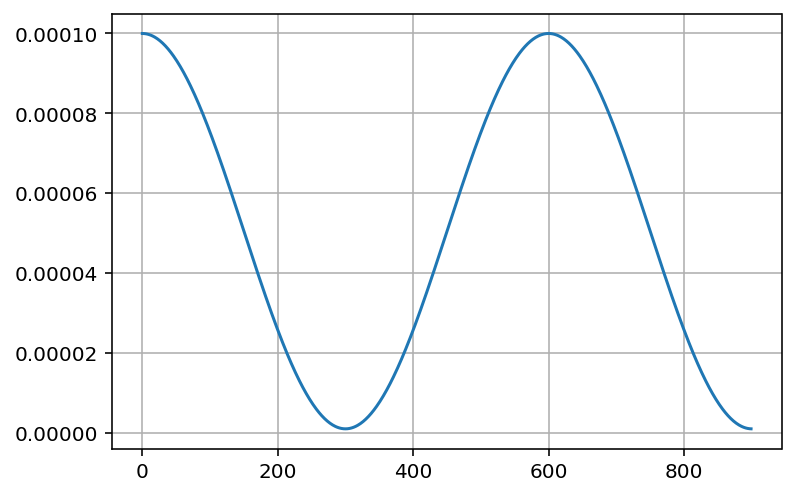

In [136]:
scheduler_test_model, optimizer = get_simple_model_optimizer()
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=300, eta_min=0.000001)
draw_learning_rate_curve(optimizer, scheduler)

Выше поведение шедулера для финального обучения 15 эпох. lr изменяется от 0.0001 до 0.000001.

In [26]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(device)

model = YOLO().to(device)
# сохраняем параметры сетки в wandb + просим следить за градиентами сетки
wandb.watch(model, log="all");

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.0005)
# scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=0.1, end_factor=1.0, total_iters=10, last_epoch=-1, verbose=False)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=300, eta_min=0.000001)
criterion = YoloLoss()

cuda:0


In [27]:
n_epochs = 15

In [28]:
best_map = 0
best_loss = 100

for epoch in range(n_epochs):
    clear_output()
    print(f'Текущая эпоха: {epoch + 1}')
    
    model.train().to(device)                # отправляем модель на обучение и на ускоритель 

    for image, boxes in tqdm(train_dataloader):         # достаем данные из обуч. выборки
        image, boxes = image.to(device), boxes.to(device)   # помещаем их на ускоритель
        batch_size = boxes.shape[0]

        boxes_pred = model(image)                   # предсказываем
        boxes_pred = torch.reshape(boxes_pred, (batch_size, 7, 7, 13))
        loss = criterion(torch.abs(boxes_pred), boxes)         # считаем лосс; модуль берется, чтобы не брать корень
                                                               # из отрицательных значений и не получать NaN 
        
        loss.backward()                     # считаем градиенты через обратное распр-е
        optimizer.step()                    # делаем градиентный шаг
        optimizer.zero_grad()               # обнуляем градиенты параметров
        wandb.log({'YOLO-loss train': loss})

        scheduler.step()

    ### валидация ###

    model.eval().to(device)                        # отправляем модель на валидацию и на ускоритель

    with torch.no_grad():                          # не считаем градиенты
        
        pred_boxes = torch.empty(0).to(device)
        true_boxes = torch.empty(0).to(device)

        batches = 0
        for image, boxes in tqdm(val_dataloader):             # достаем данные из тестовой выборки
            image, boxes = image.to(device), boxes.to(device)      # помещаем их на ускоритель
            batch_size = boxes.shape[0]

            boxes_pred = model(image)                   # предсказываем
            boxes_pred = torch.reshape(boxes_pred, (batch_size, 7, 7, 13))

            pred_boxes = torch.cat((pred_boxes, boxes_pred))
            true_boxes = torch.cat((true_boxes, boxes))
            batches += 1

        loss = criterion(torch.abs(pred_boxes), true_boxes)         # считаем лосс
        loss = loss / batches

        wandb.log({'YOLO-loss val': loss})

        all_pred_boxes, all_true_boxes = get_bound_boxes(val_dataloader, model, device)
      
        mAP = mean_average_precision(all_pred_boxes, all_true_boxes)
        wandb.log({'mAP': mAP})

        if mAP > best_map:
            best_map = mAP
            torch.save(model.state_dict(), 'YOLO_model_best_map.pt')

        if loss < best_loss:
            best_loss = loss
            torch.save(model.state_dict(), 'YOLO_model_best_loss.pt')


Текущая эпоха: 15


 15%|█▌        | 9/60 [00:06<00:31,  1.61it/s]/usr/local/lib/python3.8/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 30%|███       | 18/60 [00:11<00:24,  1.73it/s]/usr/local/lib/python3.8/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 15/15 [00:02<00:00,  6.53it/s]


## Посчитайте метрики задачи детекции на валидационной выборке

Попробуйте понять насколько хороши ваши показатели. Если числа кажутся подозрительно низкими - возможно вам стоит перепроверить ваше решение. 

In [29]:
model.eval().to(device)                        # отправляем модель на валидацию и на ускоритель

with torch.no_grad():                          # не считаем градиенты
    pred_boxes = torch.empty(0).to(device)
    true_boxes = torch.empty(0).to(device)

    batches = 0
    for image, boxes in tqdm(val_dataloader):             # достаем данные из тестовой выборки
        image, boxes = image.to(device), boxes.to(device)      # помещаем их на ускоритель
        batch_size = boxes.shape[0]

        boxes_pred = model(image)                   # предсказываем
        boxes_pred = torch.reshape(boxes_pred, (batch_size, 7, 7, 13))

        pred_boxes = torch.cat((pred_boxes, boxes_pred))
        true_boxes = torch.cat((true_boxes, boxes))
        batches += 1

    loss = criterion(torch.abs(pred_boxes), true_boxes)         # считаем лосс
    loss = loss / batches

    all_pred_boxes, all_true_boxes = get_bound_boxes(val_dataloader, model, device)
    
    mAP = mean_average_precision(all_pred_boxes, all_true_boxes)

100%|██████████| 15/15 [00:03<00:00,  4.04it/s]


In [30]:
print(f'YOLO loss (val) составляет: {loss} \n\nmAP составляет: {mAP}')

YOLO loss (val) составляет: 21.066463470458984 

mAP составляет: 0.0


## Визуализируйте предсказанные bounding box'ы для любых пяти картинок из __валидационного__ датасета.

В начале я определю функцию для пересчета относительных YOLO-координат в изначальные, а затем отрисую bounding box'ы.

In [60]:
def convert_to_normal_box_params(box_coordinates, im_w=448, im_h=448):
    """
    Перейти от [x_center, y_center, width, height] к [xmin, ymin, xmax, ymax].
    
    Обратите внимание, что параметры [x_center, y_center, width, height] - это
    относительные значение в отрезке [0, 1]

    :param: box_coordinates - координаты коробки в формате [x_center, y_center, width, height]
    :param: im_w - ширина исходного изображения
    :param: im_h - высота исходного изображения

    :return: координаты коробки в формате [xmin, ymin, xmax, ymax]
    """
    
    x_min_pl_x_max = box_coordinates[0] * im_w * 2
    x_max_mi_x_min = box_coordinates[2] * im_w

    x_max = (x_min_pl_x_max + x_max_mi_x_min) / 2
    x_min = x_max - x_max_mi_x_min

    y_min_pl_y_max = box_coordinates[1] * im_h * 2
    y_max_mi_y_min = box_coordinates[3] * im_h

    y_min = (y_min_pl_y_max - y_max_mi_y_min) / 2
    y_max = y_max_mi_y_min + y_min

    ans = [x_min, y_min, x_max, y_max]

    return ans

Я заменил датасет на даталоадер, чтобы брать сразу несколько объектов (1) и поскольку, если брать объекты из датасета, им нужно было бы добавлять еще одну размерность, это не совсем удобно (2).

**Зеленым** bounding box'ом будет обозначен ground truth, **красным** - предсказание модели.

In [61]:
# используем даталодер
image, targets = next(iter(val_dataloader))
image, targets = image.to(device), targets.to(device)

model = model.to(device) 

preds = model(image)
val_batch_size = image.shape[0]
preds = torch.reshape(preds, (val_batch_size, 7, 7, 13))

In [62]:
image.shape, targets.shape, preds.shape

(torch.Size([4, 3, 448, 448]),
 torch.Size([4, 7, 7, 13]),
 torch.Size([4, 7, 7, 13]))

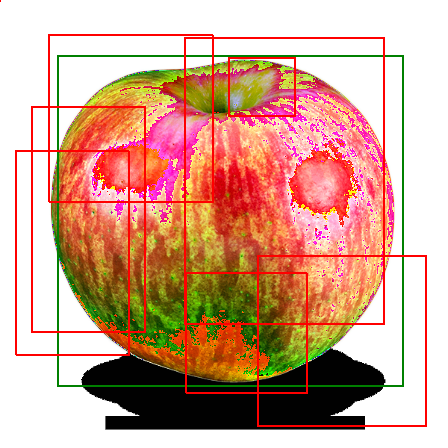

In [63]:
from PIL import ImageDraw

new_image = torchvision.transforms.ToPILImage()(image[0])
draw = ImageDraw.Draw(new_image)

for box in targets[0]:
    for i in range(box.shape[0]):
        if box[i][4] > 0:
            mybox = convert_to_normal_box_params(box[i][:4])
            draw.rectangle([(mybox[0], mybox[1]), (mybox[2], mybox[3])], outline='green', width=2)

for box in preds[0]:
    for i in range(box.shape[0]):
        if box[i][4] > 0:
            mybox = convert_to_normal_box_params(box[i][:4])
            draw.rectangle([(mybox[0], mybox[1]), (mybox[2], mybox[3])], outline='red', width=2)
        elif box[i][9] > 0:
            mybox = convert_to_normal_box_params(box[i][5:9])
            draw.rectangle([(mybox[0], mybox[1]), (mybox[2], mybox[3])], outline='red', width=2)

new_image

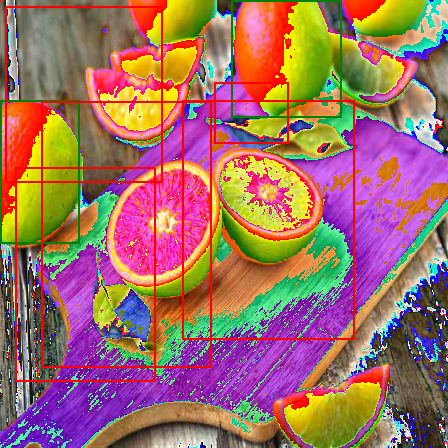

In [64]:
new_image = torchvision.transforms.ToPILImage()(image[1])
draw = ImageDraw.Draw(new_image)

for box in targets[1]:
    for i in range(box.shape[0]):
        if box[i][4] > 0:
            mybox = convert_to_normal_box_params(box[i][:4])
            draw.rectangle([(mybox[0], mybox[1]), (mybox[2], mybox[3])], outline='green', width=2)

for box in preds[1]:
    for i in range(box.shape[0]):
        if box[i][4] > 0:
            mybox = convert_to_normal_box_params(box[i][:4])
            draw.rectangle([(mybox[0], mybox[1]), (mybox[2], mybox[3])], outline='red', width=2)
        elif box[i][9] > 0:
            mybox = convert_to_normal_box_params(box[i][5:9])
            draw.rectangle([(mybox[0], mybox[1]), (mybox[2], mybox[3])], outline='red', width=2)

new_image

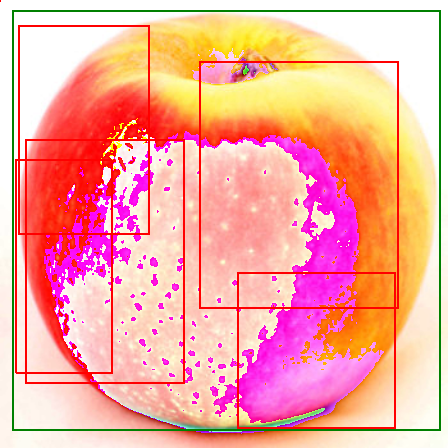

In [65]:
new_image = torchvision.transforms.ToPILImage()(image[2])
draw = ImageDraw.Draw(new_image)

for box in targets[2]:
    for i in range(box.shape[0]):
        if box[i][4] > 0:
            mybox = convert_to_normal_box_params(box[i][:4])
            draw.rectangle([(mybox[0], mybox[1]), (mybox[2], mybox[3])], outline='green', width=2)

for box in preds[2]:
    for i in range(box.shape[0]):
        if box[i][4] > 0:
            mybox = convert_to_normal_box_params(box[i][:4])
            draw.rectangle([(mybox[0], mybox[1]), (mybox[2], mybox[3])], outline='red', width=2)
        elif box[i][9] > 0:
            mybox = convert_to_normal_box_params(box[i][5:9])
            draw.rectangle([(mybox[0], mybox[1]), (mybox[2], mybox[3])], outline='red', width=2)

new_image

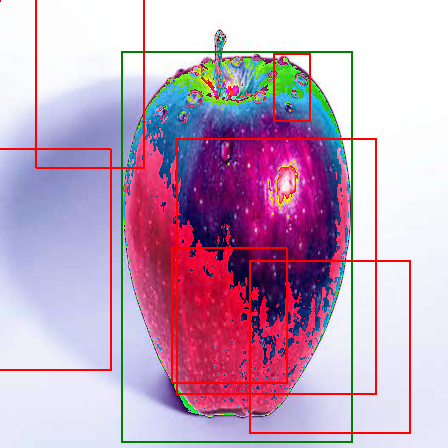

In [66]:
new_image = torchvision.transforms.ToPILImage()(image[3])
draw = ImageDraw.Draw(new_image)

for box in targets[3]:
    for i in range(box.shape[0]):
        if box[i][4] > 0:
            mybox = convert_to_normal_box_params(box[i][:4])
            draw.rectangle([(mybox[0], mybox[1]), (mybox[2], mybox[3])], outline='green', width=2)

for box in preds[3]:
    for i in range(box.shape[0]):
        if box[i][4] > 0:
            mybox = convert_to_normal_box_params(box[i][:4])
            draw.rectangle([(mybox[0], mybox[1]), (mybox[2], mybox[3])], outline='red', width=2)
        elif box[i][9] > 0:
            mybox = convert_to_normal_box_params(box[i][5:9])
            draw.rectangle([(mybox[0], mybox[1]), (mybox[2], mybox[3])], outline='red', width=2)

new_image

In [67]:
# следующая итерация
loader_iter = iter(val_dataloader)
_, _ = next(loader_iter)

image, targets = next(loader_iter)  # next(iter(val_dataloader))
image, targets = image.to(device), targets.to(device)

model = model.to(device) 

preds = model(image)
val_batch_size = image.shape[0]
preds = torch.reshape(preds, (val_batch_size, 7, 7, 13))

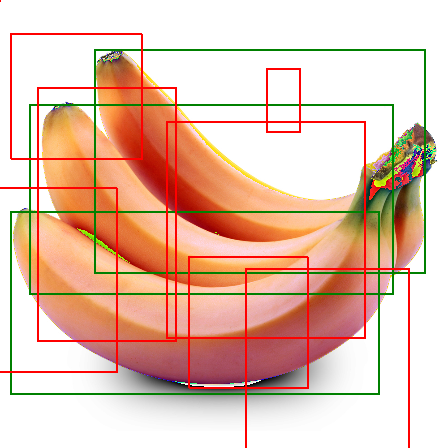

In [68]:
new_image = torchvision.transforms.ToPILImage()(image[0])
draw = ImageDraw.Draw(new_image)

for box in targets[0]:
    for i in range(box.shape[0]):
        if box[i][4] > 0:
            mybox = convert_to_normal_box_params(box[i][:4])
            draw.rectangle([(mybox[0], mybox[1]), (mybox[2], mybox[3])], outline='green', width=2)
for box in preds[0]:
    for i in range(box.shape[0]):
        if box[i][4] > 0:
            mybox = convert_to_normal_box_params(box[i][:4])
            draw.rectangle([(mybox[0], mybox[1]), (mybox[2], mybox[3])], outline='red', width=2)
        elif box[i][9] > 0:
            mybox = convert_to_normal_box_params(box[i][5:9])
            draw.rectangle([(mybox[0], mybox[1]), (mybox[2], mybox[3])], outline='red', width=2)

new_image

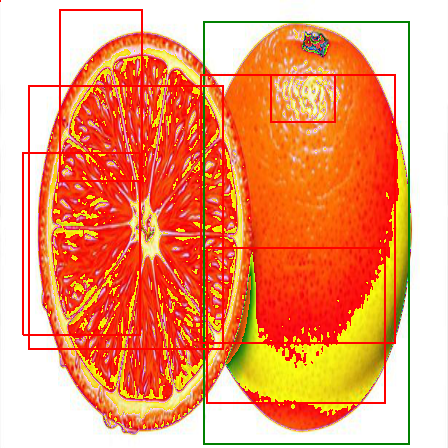

In [69]:
new_image = torchvision.transforms.ToPILImage()(image[1])
draw = ImageDraw.Draw(new_image)

for box in targets[1]:
    for i in range(box.shape[0]):
        if box[i][4] > 0:
            mybox = convert_to_normal_box_params(box[i][:4])
            draw.rectangle([(mybox[0], mybox[1]), (mybox[2], mybox[3])], outline='green', width=2)
for box in preds[1]:
    for i in range(box.shape[0]):
        if box[i][4] > 0:
            mybox = convert_to_normal_box_params(box[i][:4])
            draw.rectangle([(mybox[0], mybox[1]), (mybox[2], mybox[3])], outline='red', width=2)
        elif box[i][9] > 0:
            mybox = convert_to_normal_box_params(box[i][5:9])
            draw.rectangle([(mybox[0], mybox[1]), (mybox[2], mybox[3])], outline='red', width=2)

new_image

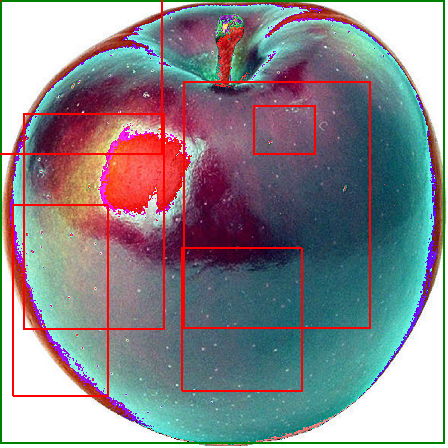

In [70]:
new_image = torchvision.transforms.ToPILImage()(image[2])
draw = ImageDraw.Draw(new_image)

for box in targets[2]:
    for i in range(box.shape[0]):
        if box[i][4] > 0:
            mybox = convert_to_normal_box_params(box[i][:4])
            draw.rectangle([(mybox[0], mybox[1]), (mybox[2], mybox[3])], outline='green', width=2)
for box in preds[2]:
    for i in range(box.shape[0]):
        if box[i][4] > 0:
            mybox = convert_to_normal_box_params(box[i][:4])
            draw.rectangle([(mybox[0], mybox[1]), (mybox[2], mybox[3])], outline='red', width=2)
        elif box[i][9] > 0:
            mybox = convert_to_normal_box_params(box[i][5:9])
            draw.rectangle([(mybox[0], mybox[1]), (mybox[2], mybox[3])], outline='red', width=2)

new_image

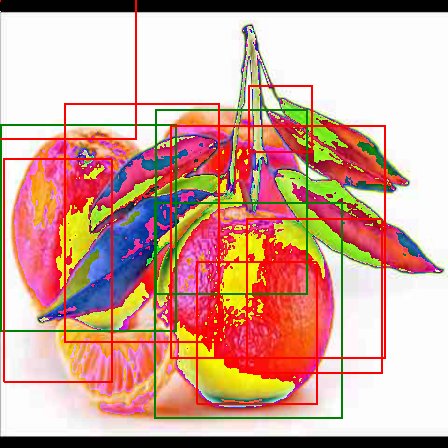

In [71]:
new_image = torchvision.transforms.ToPILImage()(image[3])
draw = ImageDraw.Draw(new_image)

for box in targets[3]:
    for i in range(box.shape[0]):
        if box[i][4] > 0:
            mybox = convert_to_normal_box_params(box[i][:4])
            draw.rectangle([(mybox[0], mybox[1]), (mybox[2], mybox[3])], outline='green', width=2)
for box in preds[3]:
    for i in range(box.shape[0]):
        if box[i][4] > 0:
            mybox = convert_to_normal_box_params(box[i][:4])
            draw.rectangle([(mybox[0], mybox[1]), (mybox[2], mybox[3])], outline='red', width=2)
        elif box[i][9] > 0:
            mybox = convert_to_normal_box_params(box[i][5:9])
            draw.rectangle([(mybox[0], mybox[1]), (mybox[2], mybox[3])], outline='red', width=2)

new_image

Выглядит неплохо, но много лишних коробок.

# Отчет об экспериментах



### Начало

Поскольку мы работаем с задачей детекциии, с картинками и боксами, в этой работе не нужно было делать EDA (исследовательский анализ данных). Единственное, что можно назвать EDA - я скачал датасет себе на компьютер и посмотрел его вручную, чтобы понимать, с чем работать.

### Датасет и лоадер
В начале (неожиданно) довольно большое время у меня заняло написание датасета. Приходилось разбираться с тем, как распарсить данные, отсортировать их (в чате я увидел подсказку Марка Блуменау про то, как сразу обработать разметку через `xmltodict`). Кроме того, возникали довольно простые, на первый взгляд, вопросы: как заполнять таргет, если в этой ячейке нет объекта, что делать со вторым боксом в таргете и т.д. С решением многих этих вопросов помогла консультация.

Далее я попробовал отрисовать картинки, которые должны подаваться в модель, и увидел очень плохие изображения: они были практически полностью белые. Я пробовал посчитать среднее значение пикселей по каналам и из станд. откл., как раньше, но это привело к тому, что они все становились черными (наблюдаемые параметры получались большими). Удивительно, но, когда я добавил самые простые параметры по умолчанию 0.5, все заработало довольно неплохо. Также я добавил аугментации, которые использовали авторы в статье.

### Модель и лосс
После этого я решил реализовать полную архитектуру из статьи (гулять так гулять). В дальнейшем оказалось, что это было верным решением, т.к. она очень быстро учится (да и датасет небольшой). 

Очень много времени заняло написание лосса для YOLO. Совершенно понятно, как он работает теоретически, но непонятно, как его эффективно реализовать. В начале я долго пытался векторизовать решение, т.к. думал, что, иначе, модель будет учиться часами, поскольку он довольно сложный. После большого числа попыток я все-таки решил попробовать сделать лосс через цикл - и не прогадал, все заработало хорошо, и модель училась быстро.

Пожалуй, самой сложной частью стало написание доп. функций. Опять же, после лекции и семинаров очевидно, как они работают, но реализовать их, поняв, что куда рпиходит и уходит, тоже сложно. Я нашел несколько их реализаций в открытых источниках, но не все были правильные, как мне показалось.

### Обучение
Изначально я хотел писать пайплайн обучения на `Lightning`, и даже начал делать это по аналогии с ДЗ №2, в котором он хорошо помог мне, но вскоре остановился, поскольку понял, что это может сыграть со мной злую шутку, т.к. `Lightning` является в некотором смысле "черным ящиком". Это здорово, если ты импортировал пред(или нет)обученную модель, поменял один слой, поставил MSE, Adam, LR и отправил ее учиться. Но здесь же, как я предполагал (и был прав) придется чинить много ошибок в своих функциях, лоссе и архитектуре. Их будет крайне сложно отследить через `Lightning`, поэтому я быстро переписал все на "голом" `PyTorch`. Я оказался прав, потому что в функциях действительно часто появлялись ошибки (больше всего я возненавидел перенос тензоров с GPU на CPU и обратно, перевод тензоров в numpy и обратно).

Однако, когда все было написано, само обучение пошло очень быстро. Единственный момент: меня очень смутило, когда, при первых запусках, градиент просто взрывался (координаты вместо [0; 1] были огромными), и лосс достигал космических отметок. Авторы YOLO писали в статье, что такое возможно, если LR слишком большой. Я уменьшил learning rate на один порядок, и все выровнялось.

#### Некоторые эксперименты

**Отчет** про мои первые запуски и дебаггинг можно посмотреть здесь: [ссылка](https://wandb.ai/rubanoww/hw-3/reports/YOLO-loss-train-22-12-21-02-20-05---VmlldzozMTkxMTIz?accessToken=sbtogjo3yv2tgq6hh99h5545ppcg1dkga0pddqenijh0hk5fhnp6h8sla8594vp2). Небольшой помехой был тот факт, что для YOLO лосса было непонятно, какое значение оптимальное, но эмпирически я понял, что лосс в районе 10-20 - неплохой результат.

Первый значимый запуск: 3 эпохи, `Adam, lr=0.0001, weight_decay=0.0005`, без `scheduler`, батч равен 4. [Ссылка на отчет](https://wandb.ai/rubanoww/hw-3/reports/YOLO-loss-train-22-12-21-17-44-13---VmlldzozMTk1NTIz?accessToken=5s816kmrmueb8yl5th9q87kqcg8phbvu5o083h7c2fw44mseze1yzrt8g6u0fxqs).

Далее - батч 8, `Adam, lr=0.0001, weight_decay=0.0005`, `scheduler` - повышение lr с 0.0001 до 0.001 (как в статье). Получилось хуже.

После серии экспериментов я понял, что батч размера 4 является наиболее оптимальным, и оставил его.

Финальные тесты, лучшие модели: обучение 10 и 15 эпох, Adam, lr=0.0001, weight_decay=0.0005, косинусный scheduler (от 0.0001 до 0.000001 раз в 300 итераций, т.е. каждые 5 эпох). 
[Ссылка на отчет](https://wandb.ai/rubanoww/hw-3/reports/YOLO-loss-train-22-12-21-19-46-06---VmlldzozMTk2MzA5?accessToken=lts1dq3sbhlc2cwy3e3j3vuopf1lwa8arlenfv168g3jle5nyuo31cueyj196qe0).



### Валидация и картинки
Позапускав модель несколько раз, я понял, что лосс довольно быстро падает, и можно идти дальше. Раздел про отрисовку картинок в начале стал для меня небольшой загадкой, т.к. я долго думал, как, во-первых, найти нужные боксы, а, во-вторых, отрисовать их, учитывая, что у них другой порядок с параметрами самой картинки. В результате, решив пару уравнений в тетради (настоящей), я понял, что можно написать функцию, которая будет возвращать относительные значения YOLO координат в необходимые 448x448, а дальше уже будет гораздо проще.


## Вывод

Удивительно, но на это ДЗ даже не пришлось тратить деньги в виде платных Колаба или Датасферы.

Если бы не начинающаяся сессия, мне было бы интересно понастраивать гиперпараметры и посмотреть, как это будет меняться на реальных боксах (очень интересно и интерактивно), но, как я понимаю, в этом ДЗ не требуется идеального качества на тестовой выборке, достаточно, чтобы лосс снижался, как это сейчас и происходит. Наверное, это логично, учитвая, что я воспользовался большинством советов авторов по реализации.



